<a href="https://colab.research.google.com/github/viswambaran/NUCapstone/blob/main/EPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tagging news headlines using Zero Shot Classification - BART model

In [ ]:
!python -V

Python 3.10.12


In [74]:
!pip install transformers
!pip install NLTK

In [75]:
import re
import textwrap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from transformers import BartForSequenceClassification, BartTokenizer, pipeline

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [76]:


financial_news_taxonomy = {
    "Market Movements": ["Stock Trends", "Commodity Prices", "Currency Rates", "Bond Yields"],
    "Company News": ["Earnings", "Product Launches", "M&A", "Legal & Regulatory", "Leadership"],
    "Economic Data": ["Employment", "Inflation", "GDP", "Consumer Sentiment"],
    "Policy & Regulation": ["Central Bank Actions", "Trade & Tax Policies", "Environmental Rules"],
    "Global Events": ["Geopolitical Issues", "Elections", "Natural Disasters", "Health Crises"],
    "Sector Highlights": ["Tech Developments", "Banking News", "Energy Updates", "Healthcare Innovations", "Real Estate Trends"],
    "Investment Insights": ["Fund Activities", "Asset Trends", "Investment Strategies"]
}

# financial_bow = [
#     "stocks", "shares", "dividend", "portfolio", "equity", "bonds", "securities",
#     "exchange", "interest", "rate", "yield", "return on investment", "ROI",
#     "capital", "asset", "liability", "balance sheet", "income statement",
#     "cash flow", "debt", "credit", "loan", "mortgage", "collateral",
#     "bankruptcy", "merger", "acquisition", "IPO", "initial public offering",
#     "commodities", "futures", "options", "hedge", "fund", "mutual fund",
#     "index", "bull market", "bear market", "recession", "economy",
#     "inflation", "deflation", "GDP", "gross domestic product", "valuation",
#     "earnings", "P/E ratio", "profit", "loss", "revenue", "expense",
#     "tax", "tariff", "divest", "stake", "capital gain", "liquidity",
#     "fiduciary", "derivative", "leverage", "broker", "trader", "analyst",
#     "rating", "outlook", "forecast", "volatile", "risk", "benchmark",
#     "monetary policy", "central bank", "Federal Reserve", "currency", "forex",
#     "exchange rate"
# ]

# print(financial_bow)


print(financial_news_taxonomy)

financial_news_terms = [item for sublist in financial_news_taxonomy.values() for item in sublist]
print(financial_news_terms)


{'Market Movements': ['Stock Trends', 'Commodity Prices', 'Currency Rates', 'Bond Yields'], 'Company News': ['Earnings', 'Product Launches', 'M&A', 'Legal & Regulatory', 'Leadership'], 'Economic Data': ['Employment', 'Inflation', 'GDP', 'Consumer Sentiment'], 'Policy & Regulation': ['Central Bank Actions', 'Trade & Tax Policies', 'Environmental Rules'], 'Global Events': ['Geopolitical Issues', 'Elections', 'Natural Disasters', 'Health Crises'], 'Sector Highlights': ['Tech Developments', 'Banking News', 'Energy Updates', 'Healthcare Innovations', 'Real Estate Trends'], 'Investment Insights': ['Fund Activities', 'Asset Trends', 'Investment Strategies']}
['Stock Trends', 'Commodity Prices', 'Currency Rates', 'Bond Yields', 'Earnings', 'Product Launches', 'M&A', 'Legal & Regulatory', 'Leadership', 'Employment', 'Inflation', 'GDP', 'Consumer Sentiment', 'Central Bank Actions', 'Trade & Tax Policies', 'Environmental Rules', 'Geopolitical Issues', 'Elections', 'Natural Disasters', 'Health Cri

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

# Cleansing dataset

In [ ]:
pd.read_csv("/analyst_ratings_processed.csv")

,Unnamed: 0,title,date,stock
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A
2,2.0,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A
...,...,...,...,...
46907,50500.0,AIG Prices 1.65B Shares of AIA Group Limited a...,2012-12-17 21:27:00-05:00,AIG
46908,50501.0,AIG Prices Hong Kong Sale of AIA at HK$29.65-H...,2012-12-17 13:24:00-05:00,AIG
46909,50502.0,"Benzinga Market Primer, Monday, December 17",2012-12-17 06:14:00-05:00,AIG
46910,50503.0,AIG Commences Sale in Hong Kong of Ordinary Sh...,2012-12-16 21:49:00-05:00,AIG


In [ ]:
# from google.colab import files
# def getLocalFiles():
#     _files = files.upload()
#     if len(_files) >0:
#        for k,v in _files.items():
#          open(k,'wb').write(v)
# getLocalFiles()

In [78]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Sample dataset loading
#headlines_df = pd.read_csv("drive/MyDrive/EPA/dataset/analyst_ratings_processed.csv")
headlines_df = pd.read_csv("/content/zero_shot_subset.csv")

# Initialize lemmatizer and define English stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def process_headline(headline):
    # Tokenize
    tokens = word_tokenize(headline)

    # Remove stopwords and lemmatize
    clean_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in stop_words]

    return " ".join(clean_tokens)

# Applying the processing function to each headline
headlines_df['processed_headline'] = headlines_df['title'].apply(process_headline)


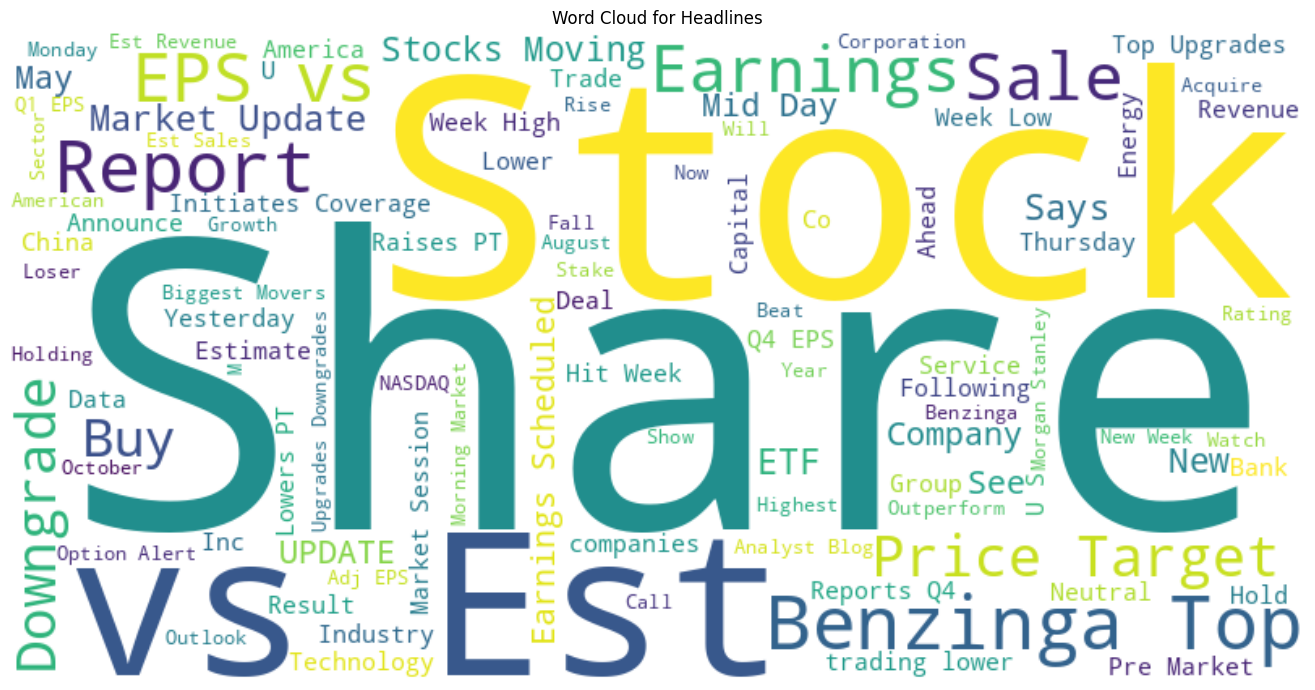

In [80]:
# Creating wordcloud
from wordcloud import WordCloud

# Generate a word cloud using a subset of the headlines
subset_headlines = headlines_df['title']
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(' '.join(subset_headlines))

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Headlines')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure that the required NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Load the dataset (assuming it's been downloaded and extracted as "stock_data.csv")

# Tokenize the headlines
tokenized_headlines = headlines_df['title'].apply(word_tokenize)

# Flatten the list of tokens and remove stopwords
all_tokens = [token.lower() for headline in tokenized_headlines for token in headline]
filtered_tokens = [token for token in all_tokens if token not in stopwords.words('english') and token.isalpha()]

# Frequency Analysis
word_freq = Counter(filtered_tokens)
common_terms = word_freq.most_common(200)  # Adjust the number based on desired length

# Extracting the terms
financial_bag_of_words = [item[0] for item in common_terms]

print(financial_bag_of_words)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['stocks', 'vs', 'eps', 'est', 'shares', 'reports', 'update', 'top', 'market', 'earnings', 'announces', 'pt', 'sales', 'benzinga', 'raises', 'buy', 'price', 'trading', 'downgrades', 'target', 'maintains', 'upgrades', 'session', 'new', 'higher', 'american', 'moving', 'stock', 'estimate', 'allergan', 'capital', 'says', 'sees', 'neutral', 'lowers', 'data', 'scheduled', 'biggest', 'initiates', 'companies', 'steel', 'us', 'company', 'coverage', 'lower', 'revenue', 'pharmaceuticals', 'morgan', 'yesterday', 'results', 'movers', 'financial', 'may', 'adobe', 'adj', 'friday', 'group', 'bank', 'gold', 'several', 'corporation', 'markets', 'industry', 'thursday', 'following', 'watch', 'outperform', 'wednesday', 'highs', 'aig', 'healthcare', 'tuesday', 'hit', 'biotech', 'analyst', 'hold', 'dividend', 'eagle', 'deal', 'systems', 'fda', 'monday', 'accenture', 'news', 'trade', 'highest', 'pharma', 'set', 'guidance', 'rating', 'offering', 'technologies', 'technology', 'beats', 'aetna', 'air', 'autodesk'

In [ ]:
headlines_df.head()

,Unnamed: 0,title,date,stock,processed_headline
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A,Stocks Hit 52-Week Highs Friday
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A,Stocks Hit 52-Week Highs Wednesday
2,2.0,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A,71 Biggest Movers Friday
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A,46 Stocks Moving Friday 's Mid-Day Session
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A,B Securities Maintains Neutral Agilent Technol...


In [ ]:
from transformers.models.bart.modeling_bart import BartForConditionalGeneration
model_name = "facebook/bart-large-mnli"
tokeniser = BartTokenizer.from_pretrained(model_name)
model = BartForSequenceClassification.from_pretrained(model_name)
model2 = BartForConditionalGeneration.from_pretrained(model_name)

classifier = pipeline(
    task="zero-shot-classification",
    model=model_name,
    tokenizer=tokeniser,
    device=device.index
)

# Initialize zero-shot classifier
#classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")


In [ ]:
# def softmax_results(results:dict):
#   _categories=zip(results['labels'], results['scores'])
#   sorted_categories=sorted(_categories, key=lambda x:x[1], reverse=True)
#   for category, score in sorted_categories[:1]:
#     print(f"{category}: {score:.3f}")


#   def softmax_results(results:dict):
#     _categories = zip(results['labels'], results['scores'])
#     sorted_categories = sorted(_categories, key=lambda x: x[1], reverse=True)
#     # Return the top category and its score
#     return sorted_categories[0]

In [ ]:
# def classify_headline(headline, labels, top3=False):
#     if not top3:
#       result = classifier(headline, labels)
#       return result['labels'][0]
#     else:
#       result = classifier(headline, labels)
#       return softmax_results(result)


def softmax_results(results:dict):
    _categories = zip(results['labels'], results['scores'])
    sorted_categories = sorted(_categories, key=lambda x: x[1], reverse=True)
    # Return the top category and its score
    if sorted_categories:
        return sorted_categories[0]
    else:
        return None, None

def classify_headline(headline, labels):
    result = classifier(headline, labels)
    if result and 'labels' in result and 'scores' in result:
        top_category, top_score = softmax_results(result)
        return top_category, top_score
    else:
        return None, None

#headlines_df['predicted_label'] = headlines_df['title'].apply(lambda x: classify_headline(x, financial_bow))

In [ ]:
classify_headline("Stock growth in yearrs", financial_news_terms)

('Stock Trends', 0.3517166078090668)

In [ ]:
# shortend_df = headlines_df.copy()
# shortend_df = shortend_df[0:1000]
shortend_df = pd.read_csv("/content/zero_shot_subset.csv")

# shortend_df['predicted_label'] = shortend_df['title'].apply(lambda x: classify_headline(x, financial_news_terms))
revised_taxonomy = [
    "Market Trends",
    "Company News",
    "Regulations & Policies",
    "Economic Indicators",
    "Global Events",
    "Industry Updates",
    "Investment News"
]

hierarchical_taxonomy = {
    "Market Trends": ["Stock Trends", "Commodity Prices", "Currency Rates", "Bond Yields"],
    "Company News": ["Earnings", "Product Launches", "M&A", "Leadership"],
    "Regulations & Policies": ["Legal & Regulatory", "Trade & Tax Policies", "Environmental Rules", "Central Bank Actions"],
    "Economic Indicators": ["Inflation", "GDP", "Consumer Sentiment", "Employment"],
    "Global Events": ["Geopolitical Issues", "Elections", "Natural Disasters", "Health Crises"],
    "Industry Updates": ["Tech Developments", "Banking News", "Energy Updates", "Healthcare Innovations", "Real Estate Trends"],
    "Investment News": ["Fund Activities", "Asset Trends", "Investment Strategies"]
}

# Apply the function to the DataFrame and unpack the results into two new columns
shortend_df['predicted_label'], shortend_df['predicted_score'] = zip(*shortend_df['title'].apply(lambda x: classify_headline(x, revised_taxonomy)))

In [ ]:
shortend_df

,Unnamed: 0,title,date,stock,processed_headline,predicted_label
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A,Stocks Hit 52-Week Highs Friday,Stock Trends
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A,Stocks Hit 52-Week Highs Wednesday,Stock Trends
2,2.0,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A,71 Biggest Movers Friday,Stock Trends
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A,46 Stocks Moving Friday 's Mid-Day Session,Stock Trends
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A,B Securities Maintains Neutral Agilent Technol...,Investment Strategies
...,...,...,...,...,...,...
995,1001.0,High Desert Gold Identifies Strong Gold Minera...,2009-08-18 12:51:00-04:00,A,High Desert Gold Identifies Strong Gold Minera...,GDP
996,1002.0,North American Tungsten Announces Updated 43-1...,2009-08-18 12:46:00-04:00,A,North American Tungsten Announces Updated 43-1...,Fund Activities
997,1003.0,Vena Enters Into Joint Venture to Develop Puca...,2009-08-18 12:15:00-04:00,A,Vena Enters Joint Venture Develop Pucara Au/Cu...,GDP
998,1004.0,ABLYNX ANNOUNCES POSITIVE PHASE I RESULTS FOR ...,2009-08-18 12:06:00-04:00,A,ABLYNX ANNOUNCES POSITIVE PHASE RESULTS SUBCUT...,Earnings


In [ ]:
shortend_df.to_csv('classified_dataset_revised_taxonomy.csv', index=False)
from google.colab import files

files.download('classified_dataset_revised_taxonomy.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Reading in classified labels dataframe (previously generated owing to time)

classfied_headlines_df = pd.read_csv("/content/classified_dataset_revised_taxonomy.csv")

In [ ]:
classfied_headlines_df[['title', 'predicted_label', 'predicted_score']]

,title,predicted_label,predicted_score
0,Top Stocks In The Surety & Title Insurance Ind...,Investment News,0.321789
1,Asterias Provides 6 Mo. Data Readout From Its ...,Company News,0.419818
2,ONEOK Partners to Participate in Bakken Day,Company News,0.428684
3,Shares of Broadsoft to Resume Trade at 4:35PM EST,Investment News,0.350094
4,"Courier Corp Holder Gamco Reports 6.97%, Up Fr...",Company News,0.515811
...,...,...,...
995,Hearing Ares in Talks To Acquire Kayne Anderson,Company News,0.438509
996,Alibaba becomes Major Olympics Sponsor through...,Global Events,0.400902
997,A Peek Into The Market Before The Trading Starts,Market Trends,0.405760
998,"Stocks Which Set New 52-Week Low Yesterday, Mo...",Investment News,0.333423


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_2, *['predicted_score'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_3, *['predicted_score'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_4, *['predicted_label'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_5, *['predicted_score', 'predicted_label'], **{'inner': 'box'})
chart

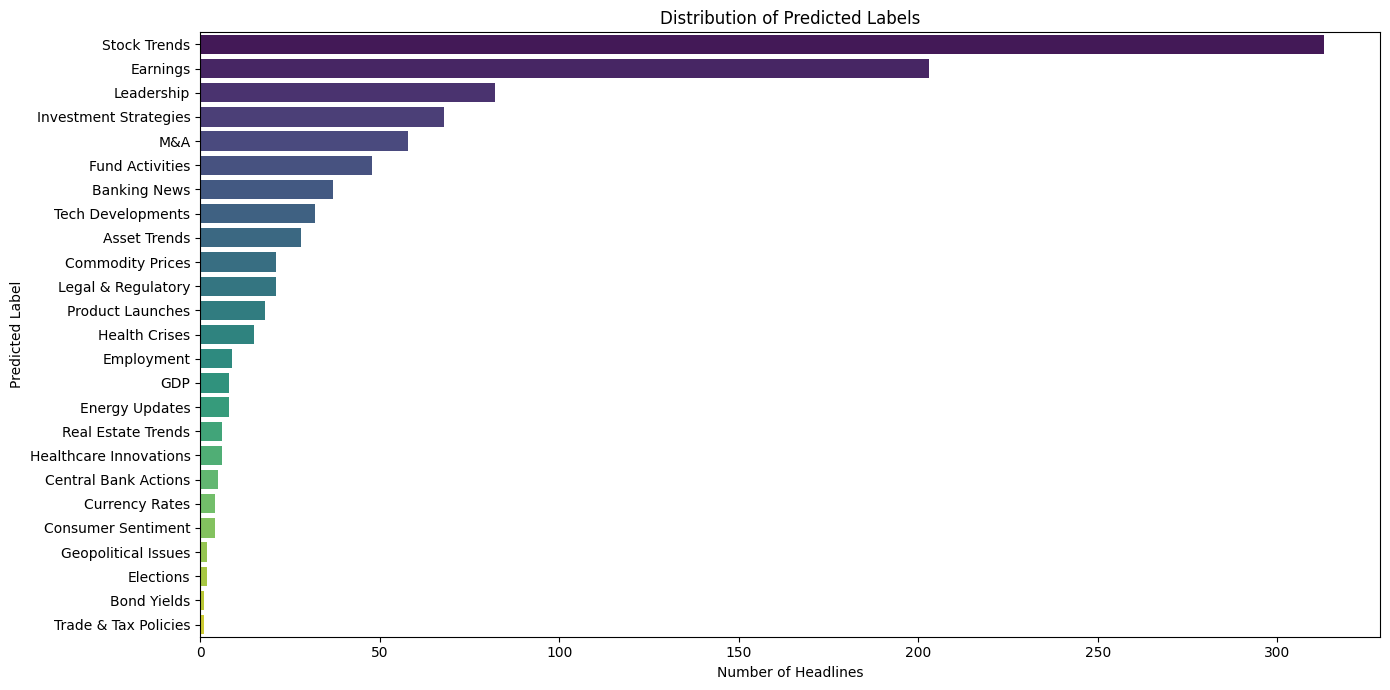

In [ ]:
# EDA for classified dataset using initial larger bag of words

wider_labelled_df = pd.read_csv("classified_dataset_randomsample.csv")
concise_labelled_df = pd.read_csv("classified_dataset_revised_taxonomy.csv")

#Distribution of predicted label (wider df)

# Distribution of Predicted Labels
plt.figure(figsize=(14, 7))
sns.countplot(y=wider_labelled_df['predicted_label'], order=wider_labelled_df['predicted_label'].value_counts().index, palette="viridis")
plt.title('Distribution of Predicted Labels')
plt.xlabel('Number of Headlines')
plt.ylabel('Predicted Label')
plt.tight_layout()
plt.show()

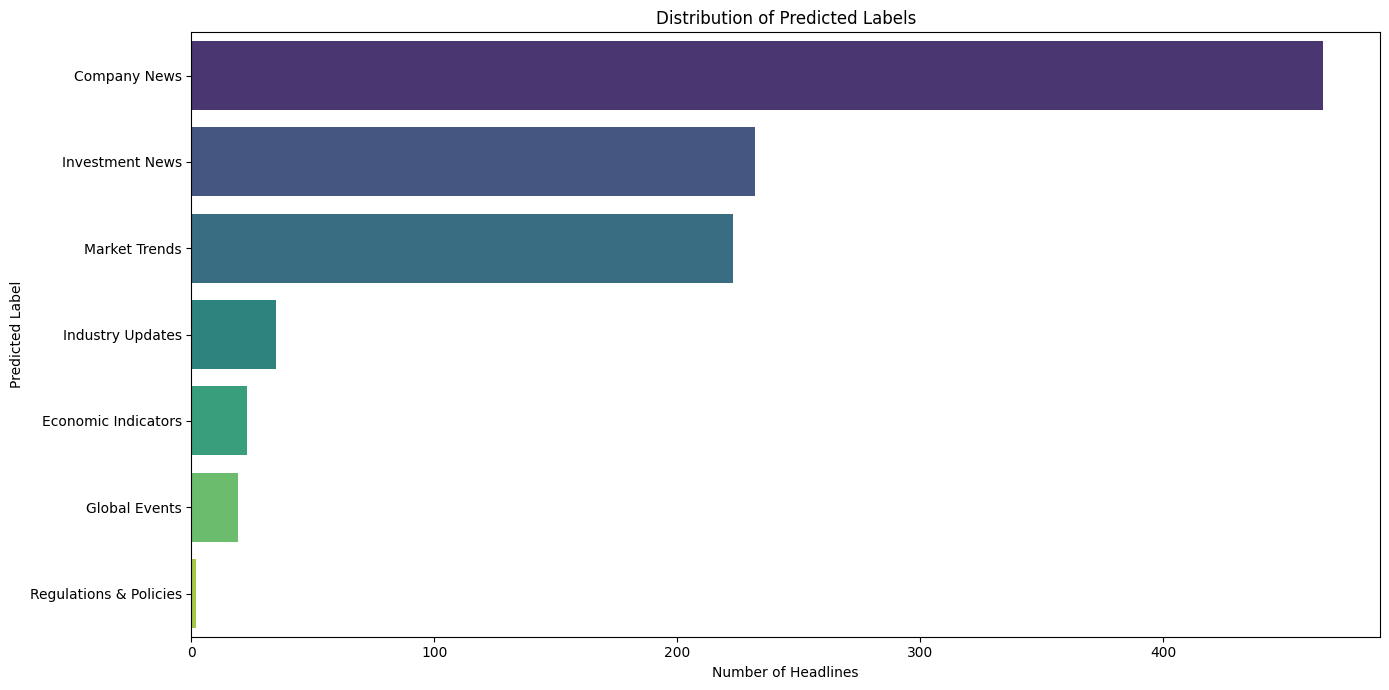

In [ ]:
# Comparison with concise categories
# Distribution of Predicted Labels
plt.figure(figsize=(14, 7))
sns.countplot(y=concise_labelled_df['predicted_label'], order=concise_labelled_df['predicted_label'].value_counts().index, palette="viridis")
plt.title('Distribution of Predicted Labels')
plt.xlabel('Number of Headlines')
plt.ylabel('Predicted Label')
plt.tight_layout()
plt.show()


In [ ]:
pd.read_csv("classified_dataset_randomsample.csv")

,Unnamed: 0,title,date,stock,predicted_label,predicted_score
0,963395.0,Top Stocks In The Surety & Title Insurance Ind...,2010-04-13 05:00:00-04:00,ORI,Stock Trends,0.212872
1,102011.0,Asterias Provides 6 Mo. Data Readout From Its ...,2018-07-17 07:05:00-04:00,AST,Asset Trends,0.119093
2,952152.0,ONEOK Partners to Participate in Bakken Day,2010-08-04 16:22:00-04:00,OKS,Employment,0.310162
3,189463.0,Shares of Broadsoft to Resume Trade at 4:35PM EST,2013-11-04 16:12:00-05:00,BSFT,Stock Trends,0.262489
4,535387.0,"Courier Corp Holder Gamco Reports 6.97%, Up Fr...",2015-03-30 16:20:00-04:00,GBL,Earnings,0.254412
...,...,...,...,...,...,...
995,748895.0,Hearing Ares in Talks To Acquire Kayne Anderson,2015-06-10 15:41:00-04:00,KYN,M&A,0.282106
996,132726.0,Alibaba becomes Major Olympics Sponsor through...,2017-01-19 06:04:00-05:00,BABA,Leadership,0.189976
997,1029212.0,A Peek Into The Market Before The Trading Starts,2011-06-07 07:31:00-04:00,PPL,Stock Trends,0.129896
998,622004.0,"Stocks Which Set New 52-Week Low Yesterday, Mo...",2018-11-27 11:26:00-05:00,HNRG,Stock Trends,0.207916


In [ ]:
# Rename the columns in each dataframe before merging
wider_labelled_df = wider_labelled_df.rename(columns={
    'predicted_label': 'sub_category',
    'predicted_score': 'sub_category_predicted_score'
})

concise_labelled_df = concise_labelled_df.rename(columns={
    'predicted_label': 'parent_category',
    'predicted_score': 'parent_predicted_score'
})

# Merge the datasets
merged_df = pd.merge(wider_labelled_df, concise_labelled_df[['title', 'parent_category', 'parent_predicted_score']],
                     on='title', how='inner')

# Display the first few rows of the merged dataframe with the new column names
merged_df[['title', 'parent_category', 'sub_category', 'parent_predicted_score', 'sub_category_predicted_score']].head()

merged_df.to_csv("zero_shot_results.csv")

files.download("zero_shot_results.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

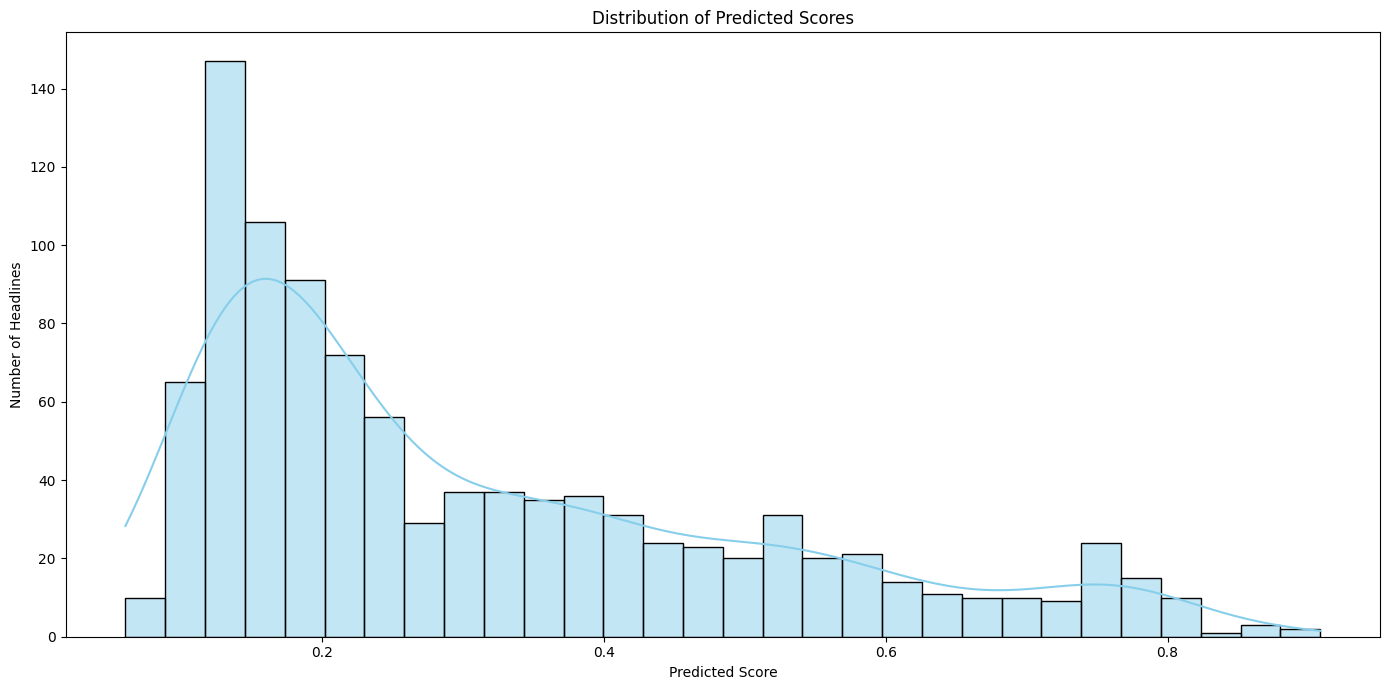

In [ ]:
# Distribution of scores v(wider bag)

# Distribution of Predicted Scores
plt.figure(figsize=(14, 7))
sns.histplot(wider_labelled_df['predicted_score'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Predicted Scores')
plt.xlabel('Predicted Score')
plt.ylabel('Number of Headlines')
plt.tight_layout()
plt.show()


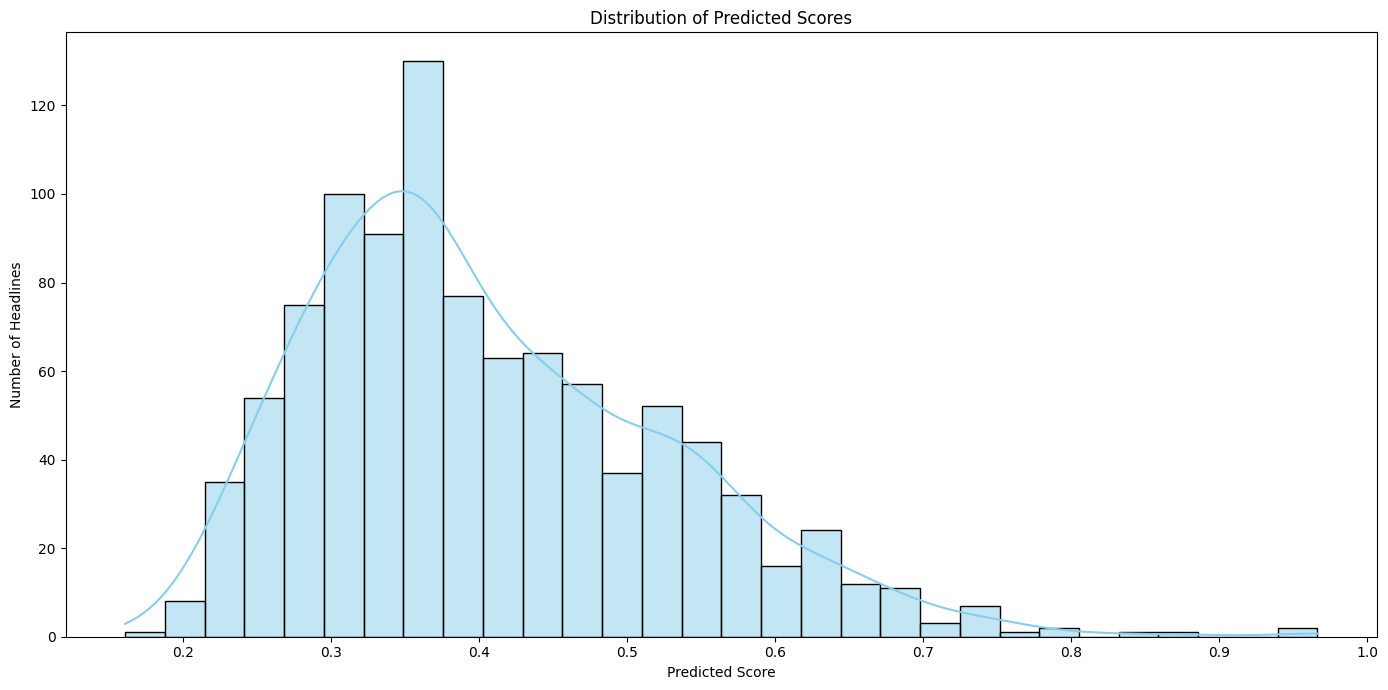

In [ ]:
# Distribution of scores v(concise bag)

# Distribution of Predicted Scores
plt.figure(figsize=(14, 7))
sns.histplot(concise_labelled_df['predicted_score'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Predicted Scores')
plt.xlabel('Predicted Score')
plt.ylabel('Number of Headlines')
plt.tight_layout()
plt.show()

<ipython-input-73-e3596cd474e1>:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=merged_df, y='parent_category', x='parent_predicted_score', ax=axes[1, 0], ci=None)
<ipython-input-73-e3596cd474e1>:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=merged_df, y='sub_category', x='sub_category_predicted_score', ax=axes[2, 0], ci=None, order=merged_df.groupby("sub_category")["sub_category_predicted_score"].mean().sort_values(ascending=False).index)


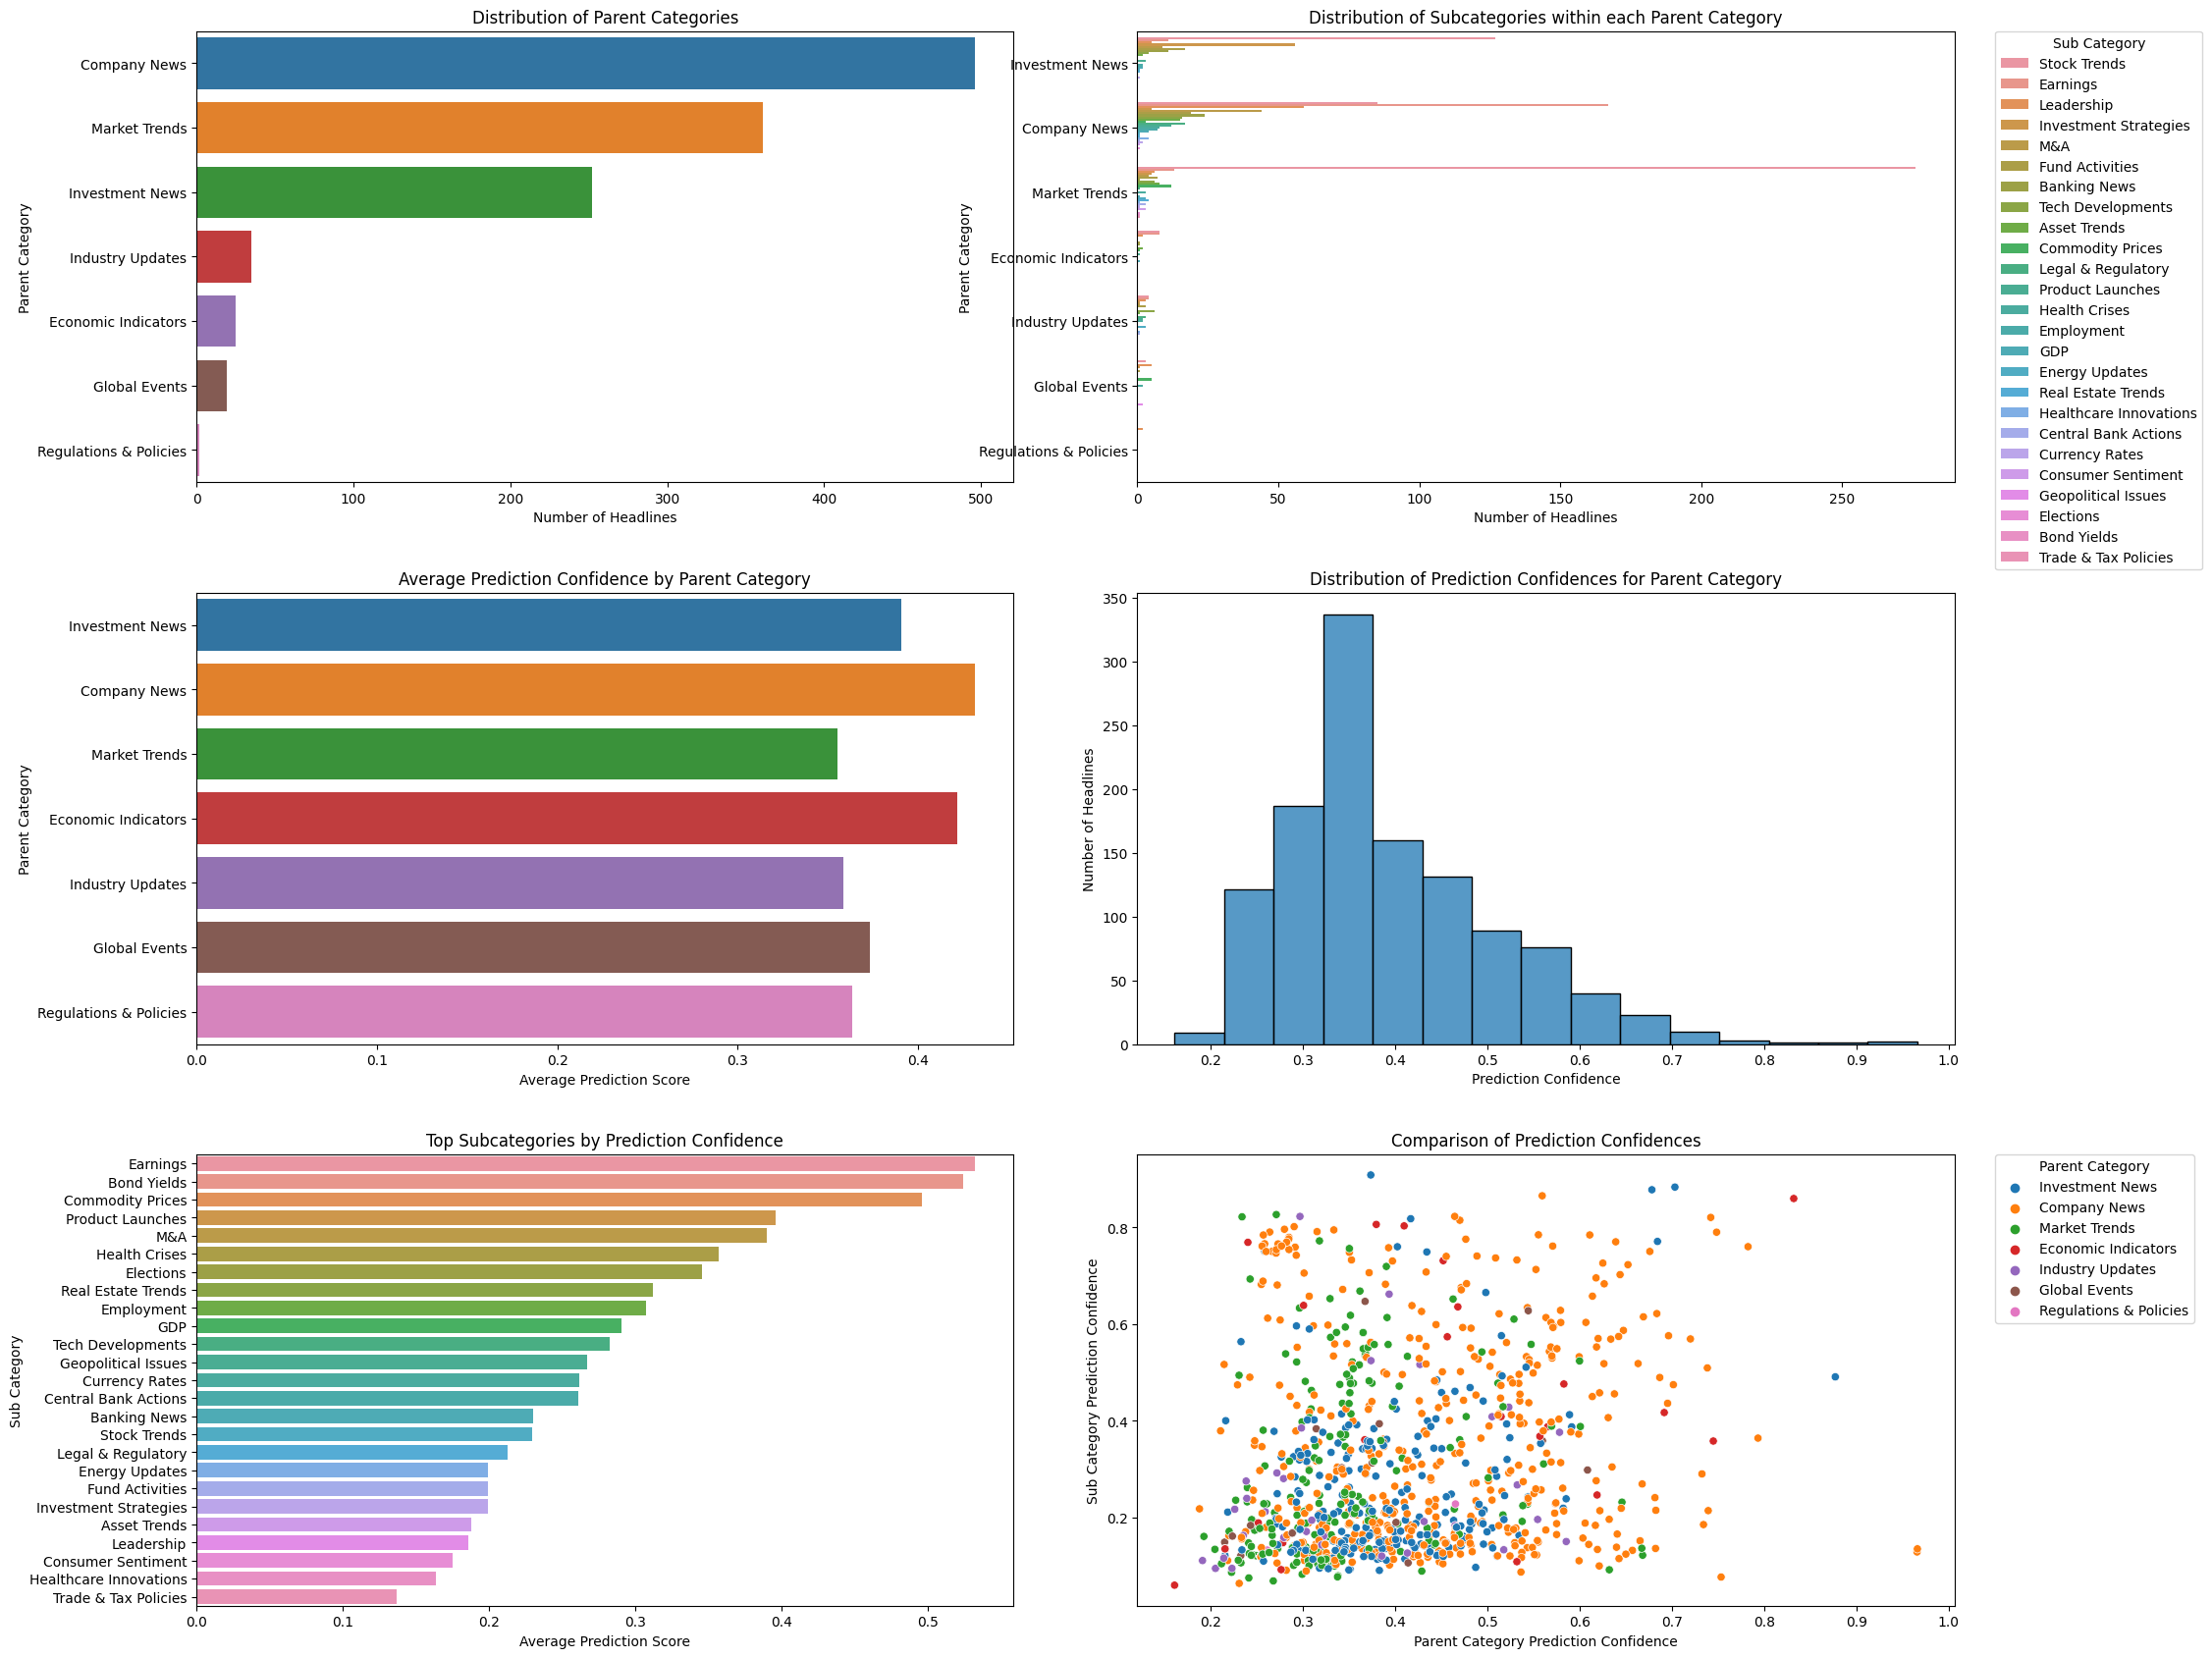

In [ ]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18))
fig.tight_layout(pad=6.0)

# Chart 1: Distribution of Parent Categories
sns.countplot(data=merged_df, y='parent_category', order=merged_df['parent_category'].value_counts().index, ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Parent Categories")
axes[0, 0].set_xlabel("Number of Headlines")
axes[0, 0].set_ylabel("Parent Category")

# Chart 2: Distribution of Subcategories within each Parent Category
sns.countplot(data=merged_df, y='parent_category', hue='sub_category', hue_order=merged_df['sub_category'].value_counts().index, ax=axes[0, 1])
axes[0, 1].set_title("Distribution of Subcategories within each Parent Category")
axes[0, 1].set_xlabel("Number of Headlines")
axes[0, 1].set_ylabel("Parent Category")
axes[0, 1].legend(title="Sub Category", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Chart 3: Average Prediction Confidence by Parent Category
sns.barplot(data=merged_df, y='parent_category', x='parent_predicted_score', ax=axes[1, 0], errorbar=None)
axes[1, 0].set_title("Average Prediction Confidence by Parent Category")
axes[1, 0].set_xlabel("Average Prediction Score")
axes[1, 0].set_ylabel("Parent Category")

# Chart 4: Distribution of Prediction Confidences for Parent Category
sns.histplot(merged_df['parent_predicted_score'], kde=False, ax=axes[1, 1], bins=15)
axes[1, 1].set_title("Distribution of Prediction Confidences for Parent Category")
axes[1, 1].set_xlabel("Prediction Confidence")
axes[1, 1].set_ylabel("Number of Headlines")

# Chart 5: Top Subcategories by Prediction Confidence
sns.barplot(data=merged_df, y='sub_category', x='sub_category_predicted_score', ax=axes[2, 0], errorbar=None, order=merged_df.groupby("sub_category")["sub_category_predicted_score"].mean().sort_values(ascending=False).index)
axes[2, 0].set_title("Top Subcategories by Prediction Confidence")
axes[2, 0].set_xlabel("Average Prediction Score")
axes[2, 0].set_ylabel("Sub Category")

# Chart 6: Comparison of Prediction Confidences
sns.scatterplot(data=merged_df, x='parent_predicted_score', y='sub_category_predicted_score', hue='parent_category', ax=axes[2, 1], palette='tab10')
axes[2, 1].set_title("Comparison of Prediction Confidences")
axes[2, 1].set_xlabel("Parent Category Prediction Confidence")
axes[2, 1].set_ylabel("Sub Category Prediction Confidence")
axes[2, 1].legend(title="Parent Category", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [ ]:
sequence_to_classify = "one day I will see the world"
candidate_labels = ['travel', 'cooking', 'dancing']
results= classifier("stock price increase for apple", financial_bow)

In [ ]:
def softmax_results(results:dict):
  _categories=zip(results['labels'], results['scores'])
  sorted_categories=sorted(_categories, key=lambda x:x[1], reverse=True)
  for category, score in sorted_categories[:3]:
    print(f"{category}: {score:.3f}")